In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../aphasia/')

Let us apply 2 transforms to $X$: 
- standardization: $X_{st(i)}=\frac{X_{(i)}-\overline{X_{(i)}}}{\sigma(X_{(i)})}$</br></br>
- minmax: $X_{mm(i)}=\frac{X_{(i)} - max(X_{(i)})}{max(X_{(i)}) - min(X_{(i)})}$

where $X_{(i)}$ is the ith column of $X$. We'll run ID estimation for $X$, $X_{st}$ and $X_{mm}$

In [22]:
from aphasia.data.tabular import get_tabular_data
import numpy as np

X_mm, y = get_tabular_data('both', True, True, 'clf', False, True, '../datasets')
X_st, _ = get_tabular_data('both', True, True, 'clf', False, True, '../datasets')
X_vars = [X_st, X_mm]

First is the correlation dimension. First, we define the correlation integral:
$$
C(\epsilon) \equiv \lim_{N \to 0} \frac{1}{N^2} \sum_{i, j = 1, i \neq j}^{\infty} H\left(\epsilon-|x_i-x_j|\right)
$$
Where $H$ is the Heaviside step function:
$$
\begin{cases}
0, x < 0 \\
\frac{1}{2}, x = 0 \\
1, x > 0
\end{cases}
$$
Then, the correlation dimension is defined as:
$$
D_2 \equiv d_{cor} \equiv \lim_{\epsilon, \epsilon' \to 0^+} \frac{ln \frac{C(\epsilon)}{C(\epsilon')}}{ln \frac{\epsilon}{\epsilon'}}
$$



In [23]:
from skdim import id

for X in X_vars:
    print(id.CorrInt().fit_transform(X))

4.807980747549152
4.807980747549152


In [24]:
for X in X_vars:
    for v in ['DANCo', 'MIND_MLi', 'MIND_MLk']:
        print(id.DANCo(ver=v).fit_transform(X), end=' ')
    print()

6.997890665058235 6 6.382383687960175 
7.455062053835307 6 6.382383687960175 


ID estimation using PCA:
- FO (Fukunaga-Olsen) - # of eigenvalues that are bigger than alphaFO(=0.05) times max eigenvalue
- Fan - from "Projected principal component analysis in factor models" by Fan et al.
- maxgap - # of eigenvalues before the biggest relative gap
- ratio - # of eigenvalues needed to retain at least alphaRatio(=0.05) of the variance
- Kaiser - # of eigenvalues > 1 (mean eigenvalue)


In [25]:
lpca_var = ['FO', 'Fan', 'maxgap', 'ratio', 'Kaiser']

print(*lpca_var, sep='\t')
for X in X_vars:
    for v in lpca_var:
        print(id.lPCA(ver=v).fit_transform(X, y), end='\t')
    print()

FO	Fan	maxgap	ratio	Kaiser
9	6	88	1	12	
9	6	88	1	12	


In [26]:
for X in X_vars:
    print(id.TwoNN().fit_transform(X, y))

6.5220604837193985
6.5220604837193985


### Based on the results of intrinsic dimension estimations, we choose 7 empirically, since most methods gave reasonable estimations between 4 and 9 (reasonable is 4 <= ID <= 15)

In [11]:
import json

with open('../Pickle/params/rf.json') as f:
    params = json.load(f)
params

{'n_estimators': 45,
 'min_samples_split': 16,
 'min_samples_leaf': 6,
 'max_features': 'sqrt',
 'max_depth': 41}

In [94]:
from aphasia.models.tab_search import cross_validate
from aphasia.models.default_values import default_models
from aphasia.common.utils import plot_confusion_matrix, make_msg

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

labels = ['Acoustic-mnestic', 'Afferent motor', 'Dynamic', 'Dysarthria', 'Efferent motor', 'Efferent motor + Afferent Motor', 'Sensory']
pca = PCA(n_components=9)


def make_cm(pred):
    y_true = []
    y_pred = []
    for _ in range(10):
        tr, pr = pred.pop()
        y_true.extend(tr)
        y_pred.extend(pr)
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, target_names=labels)

In [95]:
X, y = get_tabular_data('white', False, True, 'clf', '../datasets')
X_st = (X - np.mean(X, axis=0)) / np.std(X, axis=0)  # standardized
X_mm = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))  # min-max

X = pca.fit_transform(X)
X_st = pca.fit_transform(X_st)
X_mm = pca.fit_transform(X_mm)

accuracy: (0.40884, 0.03632)
precision: (0.32919, 0.07876)
recall: (0.40884, 0.03632)
f1_score: (0.34761, 0.05283)
roc_auc: (0.60943, 0.02532)



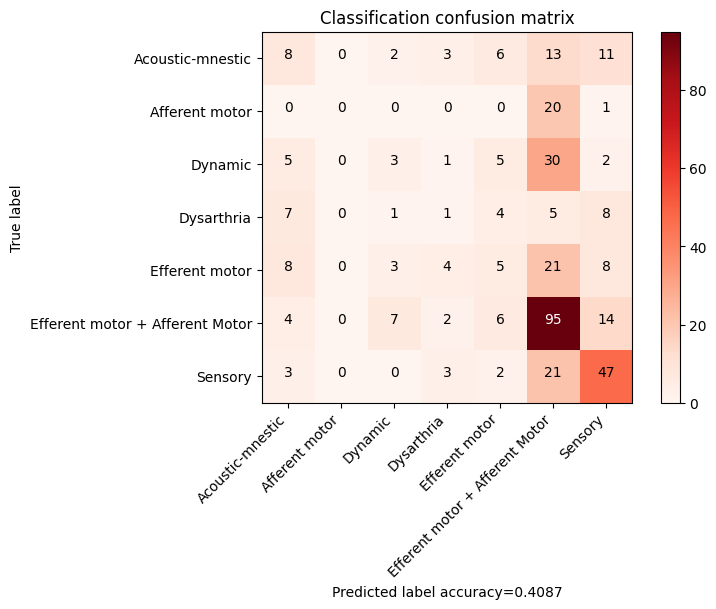

In [96]:
res, pred = cross_validate(X, y, default_models['clf']['rf'], 'clf', params)

print(make_msg(cv_results=res))
make_cm(pred)

accuracy: (0.46262, 0.05874)
precision: (0.37886, 0.09160)
recall: (0.46262, 0.05874)
f1_score: (0.38854, 0.05683)
roc_auc: (0.63875, 0.03839)



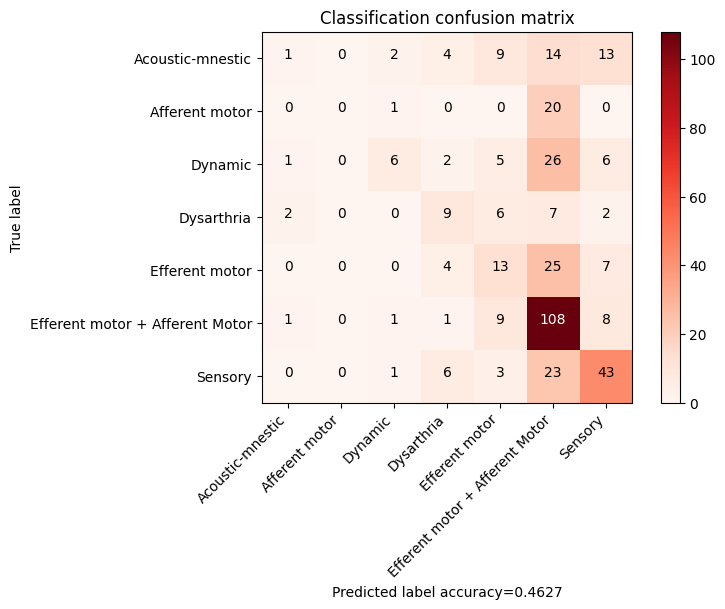

In [90]:
res, pred = cross_validate(X_st, y, default_models['clf']['rf'], 'clf', params)

print(make_msg(cv_results=res))
make_cm(pred)

accuracy: (0.42928, 0.05234)
precision: (0.34176, 0.07016)
recall: (0.42928, 0.05234)
f1_score: (0.35413, 0.04505)
roc_auc: (0.61951, 0.03596)



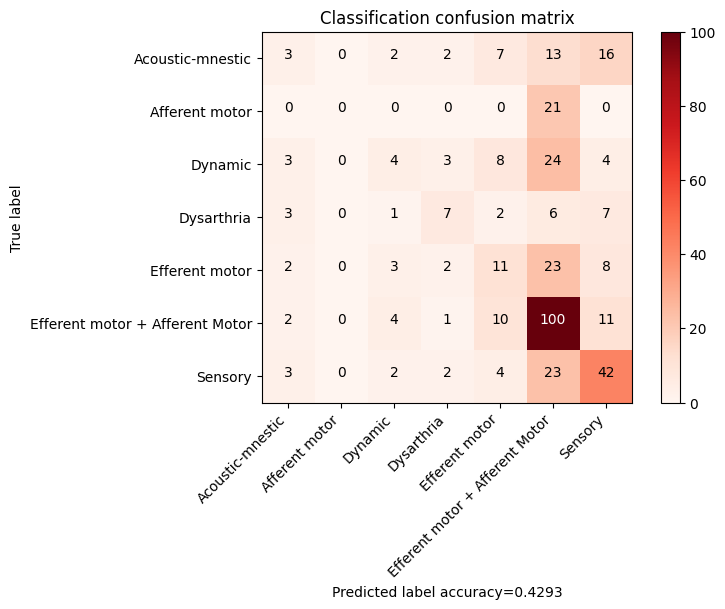

In [91]:
res, pred = cross_validate(X_mm, y, default_models['clf']['rf'], 'clf', params)

print(make_msg(cv_results=res))
make_cm(pred)

In [80]:

X, y = get_tabular_data('white', False, True, 'reg', '../datasets')
X_st = (X - np.mean(X, axis=0)) / np.std(X, axis=0)  # standardized
X_mm = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))  # min-max

pca = PCA(n_components=8)
X_st = pca.fit_transform(X_st)
X_mm = pca.fit_transform(X_mm)

In [92]:
res, pred = cross_validate(X_st, y, default_models['reg']['rf'], 'reg', params)
print(make_msg(cv_results=res))

mape: (1852981326787174.00000, 1138635978478111.75000)
mae: (1.59499, 0.13604)
r2: (0.01144, 0.11771)



In [93]:
res, pred = cross_validate(X_mm, y, default_models['reg']['rf'], 'reg', params)
print(make_msg(cv_results=res))

mape: (1785528841875795.25000, 1086260188768183.37500)
mae: (1.53759, 0.16444)
r2: (0.05768, 0.12152)

